### IMPORTS & CONFIGURATION

In [1]:
# ================== IMPORTS & CONFIGURATION ==================
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

### DATA PREPROCESSING

In [2]:
# ================== DATA PREPROCESSING ==================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    if not np.issubdtype(df.iloc[:, 0].dtype, np.number):
        df_numeric = df.iloc[:, 1:]
    else:
        df_numeric = df.copy()
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_numeric)
    return data_scaled, df_numeric.columns.tolist(), scaler

### ARIMA MODELING

In [3]:
# ================== ARIMA MODELING FUNCTION ==================
def make_stationary_and_fit_arima(data, columns):
    arima_models = []
    residuals = []
    orders = []
    
    for i in range(data.shape[1]):
        series = pd.Series(data[:, i], name=columns[i])
        
        # Handle NaN values - forward fill then drop any remaining
        series = series.ffill().dropna()
        
        if len(series) < 10:  # Skip if not enough data
            print(f"Skipping {columns[i]} - insufficient data after cleaning")
            arima_models.append(None)
            residuals.append(np.zeros(data.shape[0]))  # Placeholder
            orders.append((0, 0, 0))
            continue
            
        try:
            # Stationarity check with error handling
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = adfuller(series)
                p_value = result[1]
                
            if p_value > 0.05:
                stationary_series = series.diff().dropna()
                if len(stationary_series) < 5:  # Check if differencing left too few points
                    stationary_series = series.copy()  # Fall back to original
            else:
                stationary_series = series.copy()
                
            # ARIMA fitting with more robust error handling
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = auto_arima(
                    stationary_series,
                    seasonal=False,
                    suppress_warnings=True,
                    error_action='ignore',
                    maxiter=50,
                    n_fits=10
                )
                
            # Get residuals safely
            try:
                pred = model.predict_in_sample()
                aligned_series = stationary_series[-len(pred):]
                res = aligned_series - pred
            except:
                res = np.zeros(len(stationary_series))
                
            # Pad residuals to match original length
            padded_res = np.zeros(data.shape[0])
            padded_res[-len(res):] = res
                
            arima_models.append(model)
            residuals.append(padded_res)
            orders.append(model.order)
            
        except Exception as e:
            print(f"Failed on {columns[i]}: {str(e)}")
            arima_models.append(None)
            residuals.append(np.zeros(data.shape[0]))
            orders.append((0, 0, 0))
    
    # Convert to numpy array and trim
    residuals = np.array(residuals).T
    min_len = min(len(r[r != 0]) for r in residuals.T)  # Find first non-zero
    residuals = np.array([r[-min_len:] for r in residuals.T]).T
    
    return arima_models, residuals, orders

### TIME-GAN IMPLEMENTATION

In [31]:
# ================== TIME-GAN IMPLEMENTATION ==================
class TimeGAN:
    def __init__(self, seq_len, n_features, latent_dim=64):
        self.seq_len = seq_len
        self.n_features = n_features
        self.latent_dim = latent_dim
        
        # Build components
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.supervisor = self.build_supervisor()
        
        # Metrics trackers
        self.metrics = {
            'gen_loss': [],
            'disc_loss': [],
            'sup_loss': [],
            'disc_accuracy': []
        }
    
    def build_generator(self):
        inputs = Input(shape=(self.seq_len, self.n_features))
        x = LSTM(128, return_sequences=True)(inputs)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        x = TimeDistributed(Dense(64, activation='tanh'))(x)
        outputs = TimeDistributed(Dense(self.n_features))(x)
        return Model(inputs, outputs)
    
    def build_discriminator(self):
        inputs = Input(shape=(self.seq_len, self.n_features))
        x = GRU(64, return_sequences=False)(inputs)
        x = Dense(32, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)
        return Model(inputs, outputs)
    
    def build_supervisor(self):
        inputs = Input(shape=(self.seq_len, self.n_features))
        x = LSTM(64, return_sequences=True)(inputs)
        outputs = TimeDistributed(Dense(self.n_features))(x)
        return Model(inputs, outputs)
    
    def compile(self, lr=0.0001):
        self.generator_optimizer = Adam(lr)
        self.discriminator_optimizer = Adam(lr)
        self.supervisor_optimizer = Adam(lr)
        
        self.bce_loss = tf.keras.losses.BinaryCrossentropy()
        self.mse_loss = tf.keras.losses.MeanSquaredError()
    
    def train(self, data, epochs=1, batch_size=32):
        dataset = tf.data.Dataset.from_tensor_slices(data)
        dataset = dataset.shuffle(1000).batch(batch_size)

        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            batch_count = tf.data.experimental.cardinality(dataset).numpy()

            # tqdm progress bar for batches
            for i, batch in enumerate(tqdm(dataset, total=batch_count, desc="Training", unit="batch")):
                self.train_step(batch)
                
            # Print metrics at the end of each epoch
            print(f"Generator Loss: {self.metrics['gen_loss'][-1]:.4f}")
            print(f"Discriminator Loss: {self.metrics['disc_loss'][-1]:.4f}")
            print(f"Supervisor Loss: {self.metrics['sup_loss'][-1]:.4f}")
            print(f"Discriminator Accuracy: {self.metrics['disc_accuracy'][-1]:.4f}")
    
    def train_step(self, real_sequences):
        # Generate fake sequences
        fake_sequences = self.generator(real_sequences, training=True)
        
        # Train Discriminator
        with tf.GradientTape() as disc_tape:
            real_output = self.discriminator(real_sequences, training=True)
            fake_output = self.discriminator(fake_sequences, training=True)
            
            disc_loss_real = self.bce_loss(tf.ones_like(real_output), real_output)
            disc_loss_fake = self.bce_loss(tf.zeros_like(fake_output), fake_output)
            disc_loss = (disc_loss_real + disc_loss_fake) / 2
            
            disc_accuracy = tf.reduce_mean(
                tf.cast(tf.concat([
                    tf.round(real_output), 
                    tf.round(1 - fake_output)
                ], axis=0), tf.float32))
        
        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(
            zip(disc_grads, self.discriminator.trainable_variables))
        
        # Train Generator and Supervisor
        with tf.GradientTape() as gen_tape, tf.GradientTape() as sup_tape:
            fake_sequences = self.generator(real_sequences, training=True)
            
            # Supervisor loss
            pred_next_step = self.supervisor(
                tf.pad(fake_sequences[:, :-1, :], [[0, 0], [0, 1], [0, 0]]), 
                training=True)
            sup_loss = self.mse_loss(fake_sequences[:, 1:, :], pred_next_step[:, :-1, :])
            
            # Generator loss
            fake_output = self.discriminator(fake_sequences, training=False)
            gen_loss = self.bce_loss(tf.ones_like(fake_output), fake_output)
            
            total_gen_loss = gen_loss + 0.5 * sup_loss
        
        gen_grads = gen_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(
            zip(gen_grads, self.generator.trainable_variables))
        
        sup_grads = sup_tape.gradient(sup_loss, self.supervisor.trainable_variables)
        self.supervisor_optimizer.apply_gradients(
            zip(sup_grads, self.supervisor.trainable_variables))
        
        # Update metrics
        self.metrics['gen_loss'].append(total_gen_loss.numpy())
        self.metrics['disc_loss'].append(disc_loss.numpy())
        self.metrics['sup_loss'].append(sup_loss.numpy())
        self.metrics['disc_accuracy'].append(disc_accuracy.numpy())

    # plot training history
    def plot_training_history(self):
            epochs = range(1, len(self.metrics['gen_loss']) + 1)

            plt.figure(figsize=(12, 8))

            plt.subplot(2, 1, 1)
            plt.plot(epochs, self.metrics['gen_loss'], label='Generator Loss')
            plt.plot(epochs, self.metrics['sup_loss'], label='Supervisor Loss')
            plt.plot(epochs, self.metrics['disc_loss'], label='Discriminator Loss')
            plt.title("Loss Curves")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True)

            plt.subplot(2, 1, 2)
            plt.plot(epochs, self.metrics['disc_accuracy'], label='Discriminator Accuracy')
            plt.title("Discriminator Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()


In [39]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# ================== Modular Block Builders ==================
def build_generator(input_shape=(120, 3)):
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = TimeDistributed(Dense(64, activation='tanh'))(x)
    outputs = TimeDistributed(Dense(input_shape[-1]))(x)
    return Model(inputs, outputs, name="Generator")

def build_discriminator(input_shape=(120, 3)):
    inputs = Input(shape=input_shape)
    x = GRU(32, return_sequences=False)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="Discriminator")

def build_supervisor(input_shape=(120, 3)):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(32, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(input_shape[-1]))(x)
    return Model(inputs, outputs, name="Supervisor")

# ================== TimeGAN Class (Notebook Style) ==================
class TimeGAN_2(Model):
    def __init__(self, generator, discriminator, supervisor, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.supervisor = supervisor

        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.sup_loss_tracker = tf.keras.metrics.Mean(name="sup_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")

    def compile(self, gen_optimizer, disc_optimizer, sup_optimizer,
                gen_loss_fn, disc_loss_fn, sup_loss_fn):
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.sup_optimizer = sup_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.sup_loss_fn = sup_loss_fn

    def train_step(self, real_sequences):
        with tf.GradientTape() as disc_tape, \
             tf.GradientTape() as gen_tape, \
             tf.GradientTape() as sup_tape:

            # 1. 生成假数据
            fake_sequences = self.generator(real_sequences, training=True)

            # 2. 判别器损失
            real_output = self.discriminator(real_sequences, training=True)
            fake_output = self.discriminator(fake_sequences, training=True)

            disc_loss_real = self.disc_loss_fn(tf.ones_like(real_output), real_output)
            disc_loss_fake = self.disc_loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)

            # 3. 监督器损失
            fake_sequences_padded = tf.pad(fake_sequences[:, :-1, :], [[0, 0], [0, 1], [0, 0]])
            pred_next_step = self.supervisor(fake_sequences_padded, training=True)
            sup_loss = self.sup_loss_fn(fake_sequences[:, 1:, :], pred_next_step[:, :-1, :])

            # 4. 生成器损失（带监督）
            gen_adv_loss = self.gen_loss_fn(tf.ones_like(fake_output), fake_output)
            total_gen_loss = gen_adv_loss + 0.5 * sup_loss

        # 5. 应用梯度更新
        disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))

        gen_grads = gen_tape.gradient(total_gen_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))

        sup_grads = sup_tape.gradient(sup_loss, self.supervisor.trainable_weights)
        self.sup_optimizer.apply_gradients(zip(sup_grads, self.supervisor.trainable_weights))

        # 6. 记录指标
        self.gen_loss_tracker.update_state(total_gen_loss)
        self.sup_loss_tracker.update_state(sup_loss)
        self.disc_loss_tracker.update_state(disc_loss)

        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "sup_loss": self.sup_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result()
        }

### EVALUATION METRICS

In [32]:
# ================== EVALUATION METRICS ==================
class HybridModelEvaluator:
    def __init__(self, real_data, synthetic_data, arima_models):
        self.real_data = real_data
        self.synthetic_data = synthetic_data
        self.arima_models = arima_models
        self.scaler = MinMaxScaler()
        
    def calculate_metrics(self):
        metrics = {}
        
        # 1. Discriminative Score
        metrics.update(self._calculate_discriminative_score())
        
        # 2. Distribution Similarity
        metrics.update(self._calculate_distribution_similarity())
        
        # 3. Temporal Dynamics Metrics
        metrics.update(self._calculate_temporal_metrics())
        
        # 4. Reconstruction Error
        metrics.update(self._calculate_reconstruction_error())
        
        # 5. Anomaly Detection Performance
        metrics.update(self._calculate_anomaly_detection_metrics())
        
        return metrics
    
    def _calculate_discriminative_score(self):
        # Flatten the time dimension
        real_flat = self.real_data.reshape(-1, self.real_data.shape[-1])
        synth_flat = self.synthetic_data.reshape(-1, self.synthetic_data.shape[-1])
        
        # Create labels
        X = np.vstack([real_flat, synth_flat])
        y = np.hstack([np.zeros(len(real_flat)), np.ones(len(synth_flat))])
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        # Train classifier
        clf = IsolationForest(random_state=42).fit(X_train)
        
        # Calculate score
        score = clf.score_samples(X_test)
        real_score = score[y_test == 0]
        synth_score = score[y_test == 1]
        
        t_stat, p_value = stats.ttest_ind(real_score, synth_score)
        
        return {
            'discriminative_score': np.mean(synth_score) - np.mean(real_score),
            'discriminative_p_value': p_value
        }
    
    def _calculate_distribution_similarity(self):
        real_flat = self.real_data.reshape(-1, self.real_data.shape[-1])
        synth_flat = self.synthetic_data.reshape(-1, self.synthetic_data.shape[-1])
        
        ks_stats = []
        for i in range(real_flat.shape[1]):
            ks_stat = stats.ks_2samp(real_flat[:, i], synth_flat[:, i])
            ks_stats.append(ks_stat.statistic)
        
        return {
            'avg_ks_statistic': np.mean(ks_stats),
            'feature_ks_statistics': ks_stats
        }
    
    def _calculate_temporal_metrics(self):
        # Calculate autocorrelation similarity
        def autocorr(x, lag=1):
            return np.corrcoef(x[lag:], x[:-lag])[0, 1]
        
        real_ac = []
        synth_ac = []
        for i in range(self.real_data.shape[-1]):
            real_ac.append(autocorr(self.real_data[:, 0, i]))
            synth_ac.append(autocorr(self.synthetic_data[:, 0, i]))
        
        ac_diff = np.mean(np.abs(np.array(real_ac) - np.array(synth_ac)))
        
        return {
            'autocorrelation_difference': ac_diff,
            'real_autocorrelations': real_ac,
            'synth_autocorrelations': synth_ac
        }
    
    def _calculate_reconstruction_error(self):
        # Reconstruct synthetic data using ARIMA models
        reconstructed = []
        for seq in self.synthetic_data:
            seq_reconstructed = []
            for i, model in enumerate(self.arima_models):
                forecast = model.predict(n_periods=len(seq))
                seq_reconstructed.append(forecast + seq[:, i])
            reconstructed.append(np.stack(seq_reconstructed, axis=1))
        
        reconstructed = np.array(reconstructed)
        
        # Calculate errors
        mse = mean_squared_error(
            self.synthetic_data.flatten(),
            reconstructed.flatten())
        
        mae = mean_absolute_error(
            self.synthetic_data.flatten(),
            reconstructed.flatten())
        
        return {
            'reconstruction_mse': mse,
            'reconstruction_mae': mae
        }
    
    def _calculate_anomaly_detection_metrics(self):
        # Inject anomalies into synthetic data
        def inject_anomalies(data, ratio=0.1):
            anomalies = data.copy()
            n_anomalies = int(len(data) * ratio)
            idx = np.random.choice(len(data), n_anomalies, replace=False)
            anomalies[idx] *= 5  # Spike anomalies
            return anomalies, idx
        
        # Create dataset with labeled anomalies
        synth_normal = self.synthetic_data
        synth_anomalous, anomaly_idx = inject_anomalies(synth_normal)
        
        # Train detector on real data
        detector = IsolationForest(random_state=42)
        detector.fit(self.real_data.reshape(len(self.real_data), -1))
        
        # Evaluate detection
        scores = detector.score_samples(synth_anomalous.reshape(len(synth_anomalous), -1))
        
        # Calculate precision at k
        k = len(anomaly_idx)
        top_k = np.argsort(scores)[:k]
        true_positives = len(set(top_k) & set(anomaly_idx))
        precision = true_positives / k
        
        return {
            'anomaly_detection_precision': precision,
            'anomaly_scores': scores
        }

### MAIN PIPELINE

In [33]:
# ================== MAIN PIPELINE WITH ARIMA PROCESS LOGGING ==================
# def main():
#     # 1. Load and preprocess data
#     print("Loading and preprocessing data...")
#     data_scaled, columns, scaler = load_and_preprocess_data("../databases/processed_data/TimeGAN_data.csv")
#     print(f"Data shape: {data_scaled.shape}, Features: {columns}\n")
    
#     # 2. Fit ARIMA models and get residuals with verbose output
#     print("\nFitting ARIMA models...")
#     arima_models = []
#     residuals = []
#     orders = []
    
#     for i, col in enumerate(columns):
#         print(f"\n--- Processing {col} [Feature {i+1}/{len(columns)}] ---")
#         series = pd.Series(data_scaled[:, i], name=col)
        
#         # Handle NaN values
#         original_len = len(series)
#         series = series.ffill().dropna()
#         print(f"  NaN handling: Kept {len(series)}/{original_len} points after forward fill")
        
#         if len(series) < 10:
#             print("  WARNING: Insufficient data after cleaning - using zero residuals")
#             arima_models.append(None)
#             residuals.append(np.zeros(data_scaled.shape[0]))
#             orders.append((0,0,0))
#             continue
            
#         # Stationarity check
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             adf_result = adfuller(series)
#         p_value = adf_result[1]
#         print(f"  ADF test p-value: {p_value:.4f} ({'stationary' if p_value <= 0.05 else 'non-stationary'})")
        
#         if p_value > 0.05:
#             stationary_series = series.diff().dropna()
#             print(f"  Applied differencing (d=1), new length: {len(stationary_series)}")
#             if len(stationary_series) < 5:
#                 stationary_series = series.copy()
#                 print("  WARNING: Differencing left too few points - using original series")
#         else:
#             stationary_series = series.copy()
        
#         # ARIMA fitting
#         print("  Fitting ARIMA model...")
#         try:
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 model = auto_arima(
#                     stationary_series,
#                     seasonal=False,
#                     suppress_warnings=True,
#                     trace=True,  # This shows ARIMA fitting progress
#                     error_action='ignore',
#                     maxiter=50,
#                     n_fits=10
#                 )
#             print(f"  Best ARIMA{model.order} - AIC:{model.aic():.1f} BIC:{model.bic():.1f}")
            
#             # Get residuals
#             pred = model.predict_in_sample()
#             aligned_series = stationary_series[-len(pred):]
#             res = aligned_series - pred
            
#             # Pad residuals
#             padded_res = np.zeros(data_scaled.shape[0])
#             padded_res[-len(res):] = res
#             print(f"  Residuals range: [{res.min():.4f}, {res.max():.4f}]")
            
#             arima_models.append(model)
#             residuals.append(padded_res)
#             orders.append(model.order)
            
#         except Exception as e:
#             print(f"  ERROR: ARIMA fitting failed - {str(e)}")
#             arima_models.append(None)
#             residuals.append(np.zeros(data_scaled.shape[0]))
#             orders.append((0,0,0))
    
#     # Convert residuals to numpy array
#     residuals = np.array(residuals).T
#     min_len = min(len(r[r != 0]) for r in residuals.T)
#     residuals = np.array([r[-min_len:] for r in residuals.T]).T
#     print(f"\nFinal residuals shape: {residuals.shape}")
    
#     # 3. Prepare TimeGAN training data
#     print("\nPreparing TimeGAN training data...")
#     seq_len = 60
#     n_features = residuals.shape[1]
#     print(f"Sequence length: {seq_len}, Features: {n_features}")
    
#     def create_sequences(data, seq_length):
#         sequences = []
#         for i in range(len(data) - seq_length + 1):
#             sequences.append(data[i:i+seq_length])
#         return np.array(sequences)
    
#     residual_sequences = create_sequences(residuals, seq_len)
#     print(f"Created {len(residual_sequences)} training sequences")
    
#     # 4. Train TimeGAN
#     print("\nTraining TimeGAN...")
#     timegan = TimeGAN(seq_len=seq_len, n_features=n_features)
#     timegan.compile(lr=0.0001)
#     timegan.train(residual_sequences, epochs=1, batch_size=32)
    
#     # 5. Generate synthetic residuals
#     print("\nGenerating synthetic data...")
#     noise = np.random.normal(size=(100, seq_len, n_features))
#     synthetic_residuals = timegan.generator.predict(noise)
    
#     # 6. Reconstruct full synthetic time series
#     synthetic_data = []
#     for seq in synthetic_residuals:
#         reconstructed_seq = []
#         for i, model in enumerate(arima_models):
#             forecast = model.predict(n_periods=seq_len)
#             reconstructed_seq.append(forecast + seq[:, i])
#         synthetic_data.append(np.stack(reconstructed_seq, axis=1))
#     synthetic_data = np.array(synthetic_data)
    
#     # 7. Evaluate the hybrid model
#     print("\nEvaluating model performance...")
#     evaluator = HybridModelEvaluator(
#         real_data=residual_sequences,
#         synthetic_data=synthetic_data,
#         arima_models=arima_models
#     )
#     metrics = evaluator.calculate_metrics()
    
#     print("\n=== Evaluation Results ===")
#     for k, v in metrics.items():
#         if isinstance(v, (list, np.ndarray)):
#             print(f"{k}: {np.mean(v):.4f} (avg)")
#         else:
#             print(f"{k}: {v:.4f}")
    
#     # 8. Visualize results
#     plt.figure(figsize=(12, 6))
#     plt.plot(residual_sequences[0, :, 0], label='Real')
#     plt.plot(synthetic_data[0, :, 0], label='Synthetic', alpha=0.7)
#     plt.title("Real vs Synthetic Time Series")
#     plt.legend()
#     plt.show()

# if __name__ == "__main__":
#     main()


## Load Arima Metadata

In [34]:
import json
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def load_arima_from_full_metadata(metadata_path, data_scaled):
    with open(metadata_path, "r") as f:
        metadata = json.load(f)

    arima_models = []
    residuals = []
    columns = []
    
    for i, sensor_info in enumerate(metadata):
        sensor_name = sensor_info["sensor"]
        order = tuple(sensor_info["order"])
        columns.append(sensor_name)

        print(f"Restoring ARIMA for {sensor_name} with order {order}")
        series = pd.Series(data_scaled[:, i], name=sensor_name).ffill().dropna()

        if len(series) < 10:
            print(f"  WARNING: Not enough data for {sensor_name}")
            arima_models.append(None)
            residuals.append(np.zeros(data_scaled.shape[0]))
            continue

        try:
            model = ARIMA(series, order=order).fit()
            pred = model.predict()
            aligned = series[-len(pred):]
            res = aligned - pred

            padded_res = np.zeros(data_scaled.shape[0])
            padded_res[-len(res):] = res

            arima_models.append(model)
            residuals.append(padded_res)
            print(f"  Residuals range: [{res.min():.4f}, {res.max():.4f}]")
        except Exception as e:
            print(f"  ERROR for {sensor_name}: {e}")
            arima_models.append(None)
            residuals.append(np.zeros(data_scaled.shape[0]))

    residuals = np.array(residuals).T
    min_len = min(len(r[r != 0]) for r in residuals.T)
    residuals = np.array([r[-min_len:] for r in residuals.T]).T
    print(f"Residuals matrix shape: {residuals.shape}")

    return arima_models, residuals, columns


def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

## Load Main Pipeline with pre-trained ARIMA metadata

In [ ]:
def main():
    # Step 1: Load data and restore ARIMA models
    print("Loading data and restoring ARIMA metadata...")
    data_scaled, _, _ = load_and_preprocess_data("../databases/processed_data/TimeGAN_data.csv")
    arima_models, residuals, columns = load_arima_from_full_metadata("arima_metadata.json", data_scaled)

    # Step 2: Prepare TimeGAN training data
    print("\nPreparing TimeGAN training data...")
    seq_len = 60
    n_features = residuals.shape[1]
    residual_sequences = create_sequences(residuals, seq_len)
    print(f"Created {len(residual_sequences)} training sequences")

    # Step 3: Train TimeGAN
    print("\nTraining TimeGAN...")
    timegan = TimeGAN(seq_len=seq_len, n_features=n_features)
    timegan.compile(lr=0.0001)
    timegan.train(residual_sequences, epochs=1, batch_size=32)
    timegan.plot_training_history()

    # 4. Generate synthetic residuals
    print("\nGenerating synthetic data...")
    noise = np.random.normal(size=(100, seq_len, n_features))
    synthetic_residuals = timegan.generator.predict(noise)
    
    # 5. Reconstruct full synthetic time series
    # Step 5: Reconstruct full synthetic time series
    print("\nReconstructing synthetic time series...")
    synthetic_data = []

    for seq in synthetic_residuals:
        reconstructed_seq = []
        for i, model in enumerate(arima_models):
            if model is None:
                reconstructed_seq.append(seq[:, i])
                continue
            forecast = model.forecast(steps=seq_len)
            forecast = np.asarray(forecast)
            reconstructed_seq.append(forecast + seq[:, i])
        synthetic_data.append(np.stack(reconstructed_seq, axis=1))

    synthetic_data = np.array(synthetic_data)


    # Step 6: Evaluate the hybrid model
    print("\nEvaluating model performance...")
    evaluator = HybridModelEvaluator(
        real_data=residual_sequences,
        synthetic_data=synthetic_data,
        arima_models=arima_models
    )
    metrics = evaluator.calculate_metrics()
    
    print("\n=== Evaluation Results ===")
    for k, v in metrics.items():
        if isinstance(v, (list, np.ndarray)):
            print(f"{k}: {np.mean(v):.4f} (avg)")
        else:
            print(f"{k}: {v:.4f}")

    # Step 7: Visualize comparison for all channels
    print("\nVisualizing real vs synthetic residuals for all channels...")
    plt.figure(figsize=(14, 4 * n_features))  # 动态设置图像高度以避免拥挤

    for i in range(n_features):
        plt.subplot(n_features, 1, i + 1)
        plt.plot(residual_sequences[0, :, i], label='Real')
        plt.plot(synthetic_data[0, :, i], label='Synthetic', alpha=0.7)
        plt.title(f"Channel {i+1}: {columns[i]}")
        plt.ylabel("Residual")
        plt.legend()  # 每个 subplot 都有图例
        if i == n_features - 1:
            plt.xlabel("Time Step")

    plt.tight_layout()
    plt.show()


Loading data and restoring ARIMA metadata...
Restoring ARIMA for cooling_channel0 with order (2, 1, 2)
  Residuals range: [-0.0563, 0.0494]
Restoring ARIMA for cooling_channel1 with order (1, 1, 4)
  Residuals range: [-0.0464, 0.0397]
Restoring ARIMA for cooling_channel10 with order (5, 1, 5)
  Residuals range: [-0.0540, 0.0490]
Restoring ARIMA for cooling_channel11 with order (1, 1, 4)
  Residuals range: [-0.0419, 0.0396]
Restoring ARIMA for maxigauge_channel1 with order (3, 1, 3)
  Residuals range: [-0.0664, 0.1304]
Restoring ARIMA for maxigauge_channel2 with order (4, 1, 5)
  Residuals range: [-0.3471, 0.2746]
Restoring ARIMA for maxigauge_channel3 with order (2, 1, 5)
  Residuals range: [-0.0890, 0.0751]
Restoring ARIMA for maxigauge_channel4 with order (2, 1, 3)
  Residuals range: [-0.1059, 0.1247]
Restoring ARIMA for maxigauge_channel5 with order (1, 1, 2)
  Residuals range: [-0.1588, 0.9618]
Restoring ARIMA for maxigauge_channel6 with order (1, 1, 3)
  Residuals range: [-0.3244,

Training: 100%|██████████| 1418/1418 [14:12<00:00,  1.66batch/s]

Generator Loss: 0.6922
Discriminator Loss: 0.6931
Supervisor Loss: 0.0003
Discriminator Accuracy: 0.5625


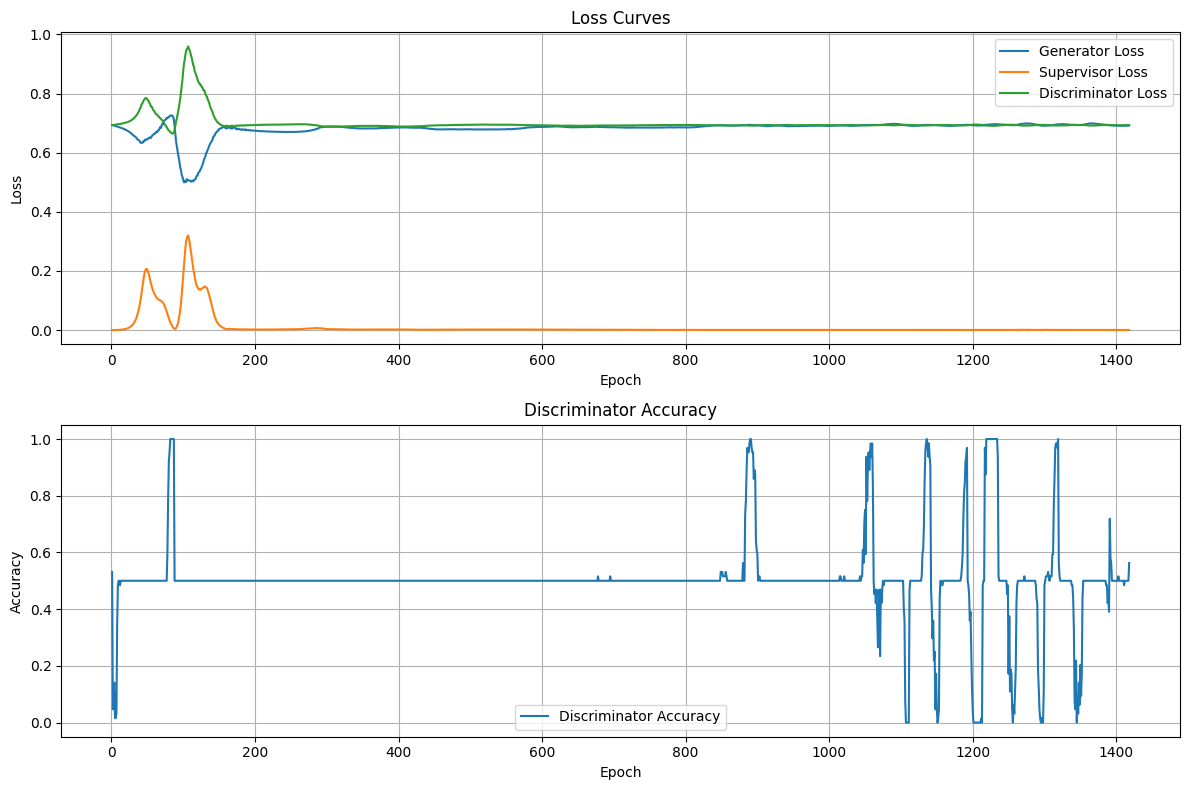


Generating synthetic data...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step

Reconstructing synthetic time series...

Evaluating model performance...


ValueError: operands could not be broadcast together with shapes (69112,) (60,) 

In [38]:
if __name__ == "__main__":
    main()

Loading data and restoring ARIMA metadata...
Restoring ARIMA for cooling_channel0 with order (2, 1, 2)
  Residuals range: [-0.0563, 0.0494]
Restoring ARIMA for cooling_channel1 with order (1, 1, 4)
  Residuals range: [-0.0464, 0.0397]
Restoring ARIMA for cooling_channel10 with order (5, 1, 5)
  Residuals range: [-0.0540, 0.0490]
Restoring ARIMA for cooling_channel11 with order (1, 1, 4)
  Residuals range: [-0.0419, 0.0396]
Restoring ARIMA for maxigauge_channel1 with order (3, 1, 3)
  Residuals range: [-0.0664, 0.1304]
Restoring ARIMA for maxigauge_channel2 with order (4, 1, 5)
  Residuals range: [-0.3471, 0.2746]
Restoring ARIMA for maxigauge_channel3 with order (2, 1, 5)
  Residuals range: [-0.0890, 0.0751]
Restoring ARIMA for maxigauge_channel4 with order (2, 1, 3)
  Residuals range: [-0.1059, 0.1247]
Restoring ARIMA for maxigauge_channel5 with order (1, 1, 2)
  Residuals range: [-0.1588, 0.9618]
Restoring ARIMA for maxigauge_channel6 with order (1, 1, 3)
  Residuals range: [-0.3244,

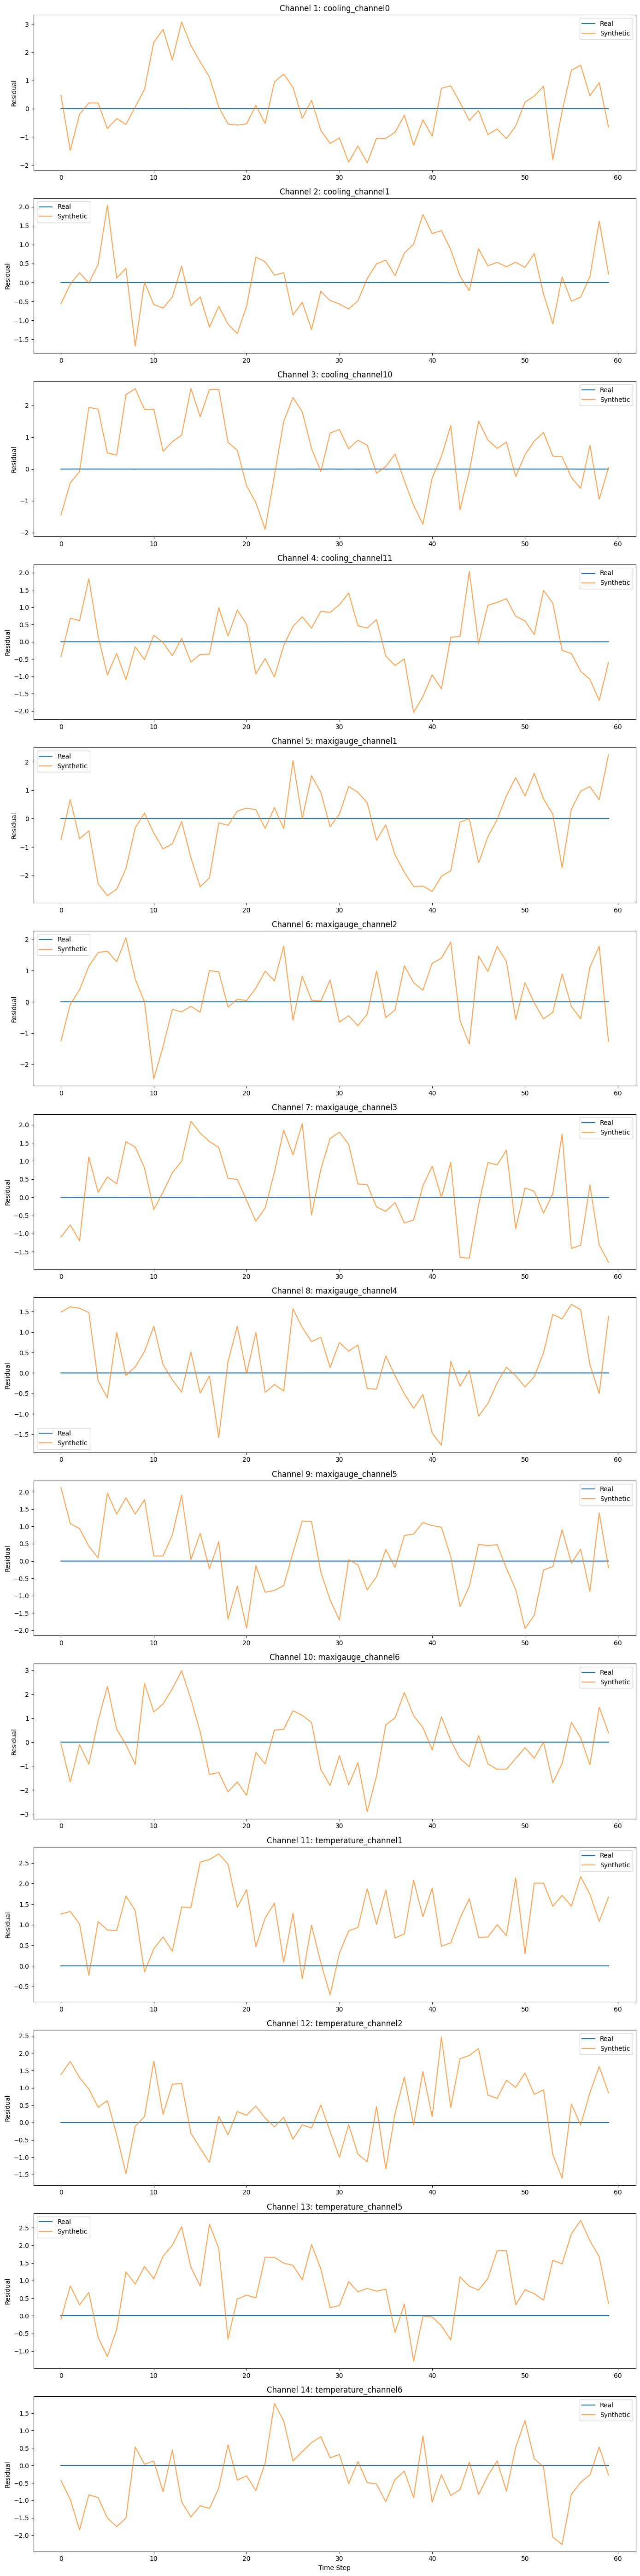

In [45]:
def main():
    # Step 1: Load data and restore ARIMA models
    print("Loading data and restoring ARIMA metadata...")
    data_scaled, _, _ = load_and_preprocess_data("../databases/processed_data/TimeGAN_data.csv")
    arima_models, residuals, columns = load_arima_from_full_metadata("arima_metadata.json", data_scaled)

    # Step 2: Prepare TimeGAN training data
    print("\nPreparing TimeGAN training data...")
    seq_len = 60
    n_features = residuals.shape[1]
    residual_sequences = create_sequences(residuals, seq_len)
    print(f"Created {len(residual_sequences)} training sequences")

    # Step 3: Train TimeGAN (custom TimeGAN_2 structure)
    print("\nTraining TimeGAN...")
    generator = build_generator(input_shape=(seq_len, n_features))
    discriminator = build_discriminator(input_shape=(seq_len, n_features))
    supervisor = build_supervisor(input_shape=(seq_len, n_features))

    timegan = TimeGAN_2(generator, discriminator, supervisor)
    timegan.compile(
        gen_optimizer=tf.keras.optimizers.Adam(1e-4),
        disc_optimizer=tf.keras.optimizers.Adam(1e-5),  # reduce to slow down D
        sup_optimizer=tf.keras.optimizers.Adam(1e-4),
        gen_loss_fn=tf.keras.losses.BinaryCrossentropy(),
        disc_loss_fn=tf.keras.losses.BinaryCrossentropy(),
        sup_loss_fn=tf.keras.losses.MeanSquaredError()
    )
    timegan.fit(residual_sequences, epochs=1, batch_size=32)

    # Step 4: Generate synthetic residuals
    print("\nGenerating synthetic data...")
    noise = np.random.normal(size=(100, seq_len, n_features))
    synthetic_residuals = timegan.generator.predict(noise)

    # Step 5: Reconstruct full synthetic time series
    print("\nReconstructing synthetic time series...")
    synthetic_data = []
    for seq in synthetic_residuals:
        reconstructed_seq = []
        for i, model in enumerate(arima_models):
            if model is None:
                reconstructed_seq.append(seq[:, i])
                continue
            forecast = model.forecast(steps=len(seq))  # Ensure forecast length matches seq
            forecast = np.asarray(forecast)
            reconstructed_seq.append(forecast + seq[:, i])
        synthetic_data.append(np.stack(reconstructed_seq, axis=1))
    synthetic_data = np.array(synthetic_data)

    # Step 6: Evaluate the hybrid model
    # print("\nEvaluating model performance...")
    # evaluator = HybridModelEvaluator(
    #     real_data=residual_sequences,
    #     synthetic_data=synthetic_data,
    #     arima_models=arima_models
    # )
    # metrics = evaluator.calculate_metrics()

    # print("\n=== Evaluation Results ===")
    # for k, v in metrics.items():
    #     if isinstance(v, (list, np.ndarray)):
    #         print(f"{k}: {np.mean(v):.4f} (avg)")
    #     else:
    #         print(f"{k}: {v:.4f}")

    # Step 7: Visualize comparison for all channels
    print("\nVisualizing real vs synthetic residuals for all channels...")
    plt.figure(figsize=(14, 4 * n_features))
    for i in range(n_features):
        plt.subplot(n_features, 1, i + 1)
        plt.plot(residual_sequences[0, :, i], label='Real')
        plt.plot(synthetic_data[0, :, i], label='Synthetic', alpha=0.7)
        plt.title(f"Channel {i+1}: {columns[i]}")
        plt.ylabel("Residual")
        plt.legend()
        if i == n_features - 1:
            plt.xlabel("Time Step")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()